# TextCNN (ver.Kkma)

In [1]:
from tensorflow import keras
import pandas as pd
import numpy as np
import pymysql
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Dense, GRU, Bidirectional, Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
conn = pymysql.connect(
                        user    = 'stocks',
                        passwd  = 'Stocks!',
                        host    = "-",
                        port    = 3306,
                        db      = 'Data',
                        charset = 'utf8'
        )

In [3]:
sql = 'SELECT stock_id, text, date, token, label FROM Token'
news = pd.read_sql(sql, conn)
news

/opt/anaconda3/envs/jupyter/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,stock_id,text,date,token,label
0,000060,2500억 모집액 못 채우고 미달 3년물 2200억에 1710억 모집 5년물 전액 ...,2022-07-15 19:54:00,"['2500', '억', '모집', '액', '못', '채우', '고', '미달',...",1
1,000060,메리츠증권은 14일 아모레G에 대해 아모레퍼시픽 부진으로 투자 매력도가 상대적으로 ...,2022-07-14 08:36:00,"['메리츠증권', '은', '14', '일', '아모레', 'G', '에', '대하...",0
2,000060,증시 과매도 PER 종목 쏟아진다 30개 PER 1 2배로 떨어져 PER 낮은 기업...,2022-07-13 17:36:00,"['증시', '과', '매도', 'PER', '종목', '쏟아지', 'ㄴ다', '3...",1
3,000060,투자의견 매수 목표주가 7만5000원 유지 메리츠증권이 13일 SK텔레콤에 대해 2...,2022-07-13 08:18:00,"['투자', '의견', '매수', '목표', '주가', '7', '만', '5000...",0
4,000060,금감원 손보사에 유사암 일반암 진단비 자료 요구 올해들어 손보사 유사암 경쟁 진단비...,2022-07-13 06:01:00,"['금감원', '손보사', '에', '유사', '암', '일반', '암', '진단'...",0
...,...,...,...,...,...
111614,402340,앱출석 후 회원가입시 80만명 한정 선착순국내 최초 가상자산 거래소 코빗이 4월 한...,2022-04-01 11:17:00,"['앱', '출석', '후', '회원', '가', '입시', '80', '만', '...",1
111615,402340,SK그룹 투자회사 SK스퀘어의 연결대상 종속회사 원스토어와 SK쉴더스가 증권신고서를...,2022-04-01 11:06:00,"['SK', '그룹', '투자', '회사', 'SK', '스퀘어', '의', '연결...",1
111616,402340,31일 증권신고서 제출 4월 기관 수요예측 SK스퀘어 자회사들인 토종 앱스토어 원스...,2022-04-01 09:00:00,"['31', '일', '증권', '신고서', '제출', '4', '월', '기관',...",1
111617,402340,삼부토건 제3자 배정증자 방식으로 SK에코플랜트에 보통주 11만 6106주 유상증...,2022-04-01 07:01:00,"['삼부', '토건', '제', '3', '자', '배정', '증자', '방식', ...",1


In [4]:
import re

def str_to_list(d):
  text = re.sub(r'[\[\'\]]', '', d)
  return text.split(", ")

news["token"] = news.token.apply(str_to_list)

In [5]:
from tqdm import tqdm
def stopword(x):
  stopword = [r'상승.*', r'하락.*', r'급등.*', r'급락.*', '상승세', '하락세', '폭등', '폭락', '오름세', '약세', '강세', '의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다', '에', '은', '는', '하']
  return [i for i in x if i not in stopword and not i.isdigit()]
tqdm.pandas()
news["token"] = news.token.progress_apply(stopword)
news

100%|██████████| 111619/111619 [05:56<00:00, 312.94it/s] 


,stock_id,text,date,token,label
0,000060,2500억 모집액 못 채우고 미달 3년물 2200억에 1710억 모집 5년물 전액 ...,2022-07-15 19:54:00,"[억, 모집, 액, 못, 채우, 고, 미달, 년, 물, 억, 억, 모, 집, 년, ...",1
1,000060,메리츠증권은 14일 아모레G에 대해 아모레퍼시픽 부진으로 투자 매력도가 상대적으로 ...,2022-07-14 08:36:00,"[메리츠증권, 일, 아모레, G, 대하, 어, 아모레, 퍼시픽, 부진, 투자, 매력...",0
2,000060,증시 과매도 PER 종목 쏟아진다 30개 PER 1 2배로 떨어져 PER 낮은 기업...,2022-07-13 17:36:00,"[증시, 매도, PER, 종목, 쏟아지, ㄴ다, 개, PER, 배, 로, 떨어지, ...",1
3,000060,투자의견 매수 목표주가 7만5000원 유지 메리츠증권이 13일 SK텔레콤에 대해 2...,2022-07-13 08:18:00,"[투자, 의견, 매수, 목표, 주가, 만, 원, 유지, 메리츠증권, 일, SK, 텔...",0
4,000060,금감원 손보사에 유사암 일반암 진단비 자료 요구 올해들어 손보사 유사암 경쟁 진단비...,2022-07-13 06:01:00,"[금감원, 손보사, 유사, 암, 일반, 암, 진단, 비, 자료, 요구, 올해, 듣,...",0
...,...,...,...,...,...
111614,402340,앱출석 후 회원가입시 80만명 한정 선착순국내 최초 가상자산 거래소 코빗이 4월 한...,2022-04-01 11:17:00,"[앱, 출석, 후, 회원, 입시, 만, 명, 한정, 선착순, 국내, 최초, 가상, ...",1
111615,402340,SK그룹 투자회사 SK스퀘어의 연결대상 종속회사 원스토어와 SK쉴더스가 증권신고서를...,2022-04-01 11:06:00,"[SK, 그룹, 투자, 회사, SK, 스퀘어, 연결, 대상, 종속, 회사, 원, 스...",1
111616,402340,31일 증권신고서 제출 4월 기관 수요예측 SK스퀘어 자회사들인 토종 앱스토어 원스...,2022-04-01 09:00:00,"[일, 증권, 신고서, 제출, 월, 기관, 수요, 예측, SK, 스퀘어, 자회사, ...",1
111617,402340,삼부토건 제3자 배정증자 방식으로 SK에코플랜트에 보통주 11만 6106주 유상증...,2022-04-01 07:01:00,"[삼부, 토건, 제, 배정, 증자, 방식, SK, 에코, 플랜트, 보통주, 만, 주...",1


In [6]:
test = news.loc[news["date"] >= '2022-07-01 00:00:00']
train = news.loc[news["date"] < '2022-07-01 00:00:00']

X_train = train['token']
y_train = train['label']
X_test = test['token']
y_test = test['label']

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(94918,) (94918,) (16701,) (16701,)


In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [8]:
threshold = 4
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 62463
등장 빈도가 3번 이하인 희귀 단어의 수: 18802
단어 집합에서 희귀 단어의 비율: 30.101019803723805
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.07036167954849475


In [9]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 43662


In [10]:
tokenizer = Tokenizer(vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [11]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [12]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)

print(len(X_train))
print(len(y_train))

94918
94918


/opt/anaconda3/envs/jupyter/lib/python3.8/site-packages/numpy/lib/function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [13]:
print('리뷰 최대 길이:', max(len(l) for l in X_train))
print('리뷰 평균 길이:', sum(map(len, X_train)) / len(X_train))

리뷰 최대 길이: 5759
리뷰 평균 길이: 489.9088054952696


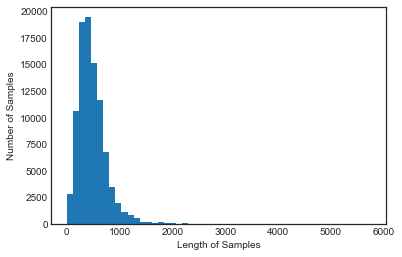

In [14]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('Length of Samples')
plt.ylabel('Number of Samples')
plt.show()

In [15]:
max_len = 800

In [16]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [17]:
embedding_dim = max_len # 임베딩 벡터의 차원
dropout_ratio = 0.4 # 드롭아웃 비율
num_filters = 2 # 커널의 수
kernel_size = 3 # 커널의 크기
hidden_units = 128 # 뉴런의 수

In [18]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Dropout(dropout_ratio))
model.add(Conv1D(num_filters, kernel_size, padding = 'valid', activation = 'relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_units, activation='relu'))
model.add(Dropout(dropout_ratio))
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

2022-08-04 23:41:54.361285: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 800)         34929600  
                                                                 
 dropout (Dropout)           (None, None, 800)         0         
                                                                 
 conv1d (Conv1D)             (None, None, 2)           4802      
                                                                 
 global_max_pooling1d (Globa  (None, 2)                0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 128)               384       
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

In [26]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)
mc = ModelCheckpoint('TextCNN_best_model(learning_rate).h5', monitor = 'val_acc', mode = 'max', verbose = 1, save_best_only = True)

In [27]:
import tensorflow as tf
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate = 0.005), loss='binary_crossentropy', metrics = ['acc'])
history = model.fit(X_train, y_train, epochs=10, validation_split = 0.2, callbacks=[es, mc], batch_size = 128)

Epoch 1/10
594/594 [==============================] - ETA: 0s - loss: 0.6907 - acc: 0.5297
Epoch 1: val_acc improved from -inf to 0.52797, saving model to TextCNN_best_model(learning_rate).h5
594/594 [==============================] - 1064s 2s/step - loss: 0.6907 - acc: 0.5297 - val_loss: 0.6931 - val_acc: 0.5280
Epoch 2/10
594/594 [==============================] - ETA: 0s - loss: 0.6788 - acc: 0.5653
Epoch 2: val_acc improved from 0.52797 to 0.55410, saving model to TextCNN_best_model(learning_rate).h5
594/594 [==============================] - 1035s 2s/step - loss: 0.6788 - acc: 0.5653 - val_loss: 0.6805 - val_acc: 0.5541
Epoch 3/10
594/594 [==============================] - ETA: 0s - loss: 0.6541 - acc: 0.6121
Epoch 3: val_acc improved from 0.55410 to 0.57101, saving model to TextCNN_best_model(learning_rate).h5
594/594 [==============================] - 1044s 2s/step - loss: 0.6541 - acc: 0.6121 - val_loss: 0.6767 - val_acc: 0.5710
Epoch 4/10
594/594 [=============================

In [28]:
loaded_model = load_model('TextCNN_best_model(learning_rate).h5')
loaded_model.evaluate(X_test, y_test)

522/522 [==============================] - 23s 44ms/step - loss: 0.7671 - acc: 0.5022


[0.767128586769104, 0.5021855235099792]

# TextCNN (ver. Okt)

In [4]:
sql = 'SELECT token, label FROM Okt_Token'
okt_token = pd.read_sql(sql, conn)
okt_token

/opt/anaconda3/envs/jupyter/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


DatabaseError: Execution failed on sql 'SELECT token, label FROM Okt_Token': (1412, 'Table definition has changed, please retry transaction')

In [ ]:
import re

def str_to_list(d):
  text = re.sub(r'[\[\'\]]', '', d)
  return text.split(", ")

okt_token["token"] = okt_token.token.apply(str_to_list)

In [ ]:
from tqdm import tqdm
def stopword(x):
  stopword = [r'상승.*', r'하락.*', r'급등.*', r'급락.*', '상승세', '하락세', '폭등', '폭락', '오름세', '약세', '강세', '의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다', '에', '은', '는', '하']
  return [i for i in x if i not in stopword and not i.isdigit()]
tqdm.pandas()
okt_token["token"] = okt_token.token.progress_apply(stopword)
okt_token

100%|██████████| 111619/111619 [02:02<00:00, 907.78it/s] 


,token,label
0,"[2500억, 모집, 액, 못, 채우고, 미달, 3년, 물, 2200억, 1710억...",1
1,"[메, 리츠, 증권, 14일, 아모레, G, 대해, 아모레퍼시픽, 부진, 투자, 매...",0
2,"[증시, 매도, PER, 종목, 쏟아진다, 개, PER, 배, 로, 떨어져, PER...",1
3,"[투자, 의견, 매수, 목표, 주가, 7만, 5000원, 유지, 메, 리츠, 증권,...",0
4,"[금감원, 손, 보사, 유사, 암, 일반, 암, 진, 단비, 자료, 요구, 올해, ...",0
...,...,...
111614,"[앱, 출석, 후, 회원, 입시, 80만, 명, 한정, 선착순, 국내, 최초, 가상...",1
111615,"[SK, 그룹, 투자, 회사, SK, 스퀘어, 연결, 대상, 종, 속, 회사, 원,...",1
111616,"[31일, 증권, 신고, 서, 제출, 4월, 기관, 수요, 예측, SK, 스퀘어, ...",1
111617,"[삼부, 토건, 제, 배정, 증자, 방식, SK, 에코, 플랜트, 보통주, 11만,...",1


In [ ]:
okt_token = pd.concat([news['date'], okt_token], axis= 1)
okt_token

,date,token,label
0,2022-07-15 19:54:00,"[2500억, 모집, 액, 못, 채우고, 미달, 3년, 물, 2200억, 1710억...",1
1,2022-07-14 08:36:00,"[메, 리츠, 증권, 14일, 아모레, G, 대해, 아모레퍼시픽, 부진, 투자, 매...",0
2,2022-07-13 17:36:00,"[증시, 매도, PER, 종목, 쏟아진다, 개, PER, 배, 로, 떨어져, PER...",1
3,2022-07-13 08:18:00,"[투자, 의견, 매수, 목표, 주가, 7만, 5000원, 유지, 메, 리츠, 증권,...",0
4,2022-07-13 06:01:00,"[금감원, 손, 보사, 유사, 암, 일반, 암, 진, 단비, 자료, 요구, 올해, ...",0
...,...,...,...
111614,2022-04-01 11:17:00,"[앱, 출석, 후, 회원, 입시, 80만, 명, 한정, 선착순, 국내, 최초, 가상...",1
111615,2022-04-01 11:06:00,"[SK, 그룹, 투자, 회사, SK, 스퀘어, 연결, 대상, 종, 속, 회사, 원,...",1
111616,2022-04-01 09:00:00,"[31일, 증권, 신고, 서, 제출, 4월, 기관, 수요, 예측, SK, 스퀘어, ...",1
111617,2022-04-01 07:01:00,"[삼부, 토건, 제, 배정, 증자, 방식, SK, 에코, 플랜트, 보통주, 11만,...",1


In [ ]:
test = okt_token.loc[okt_token["date"] >= '2022-07-01 00:00:00']
train = okt_token.loc[okt_token["date"] < '2022-07-01 00:00:00']

X_train = train['token']
y_train = train['label']
X_test = test['token']
y_test = test['label']

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(94918,) (94918,) (16701,) (16701,)


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
threshold = 4
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 62463
등장 빈도가 3번 이하인 희귀 단어의 수: 18802
단어 집합에서 희귀 단어의 비율: 30.101019803723805
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.07036167954849475


In [ ]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 43662


In [ ]:
tokenizer = Tokenizer(vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

X_trian = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)

print(len(X_train))
print(len(y_train))

In [ ]:
print('리뷰 최대 길이:', max(len(l) for l in X_train))
print('리뷰 평균 길이:', sum(map(len, X_trian)) / len(X_train))

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('Length of Samples')
plt.ylabel('Number of Samples')
plt.show()

In [ ]:
max_len = 800

In [ ]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [ ]:
embedding_dim = max_len # 임베딩 벡터의 차원
dropout_ratio = 0.4 # 드롭아웃 비율
num_filters = 2 # 커널의 수
kernel_size = 3 # 커널의 크기
hidden_units = 128 # 뉴런의 수

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Dropout(dropout_ratio))
model.add(Conv1D(num_filters, kernel_size, padding = 'valid', activation = 'relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_units, activation='relu'))
model.add(Dropout(dropout_ratio))
model.add(Dense(1, activation = 'sigmoid'))

In [ ]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)
mc = ModelCheckpoint('TextCNN_best_model(okt).h5', monitor = 'val_acc', mode = 'max', verbose = 1, save_best_only = True)

In [ ]:
import tensorflow as tf
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate = 0.005), loss='binary_crossentropy', metrics = ['acc'])
history = model.fit(X_train, y_train, epochs=10, validation_split = 0.2, callbacks=[es, mc], batch_size = 128)

In [ ]:
loaded_model = load_model('TextCNN_best_model(okt).h5')
loaded_model.evaluate(X_test, y_test)